In [5]:
from fastai.vision.all import *

In [8]:
paintings = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_y=parent_label,
                    item_tfms=RandomResizedCrop(244, min_scale=0.3),
                    batch_tfms=aug_transforms())

In [9]:
dls= paintings.dataloaders('resources/cleaned', num_workers=0)

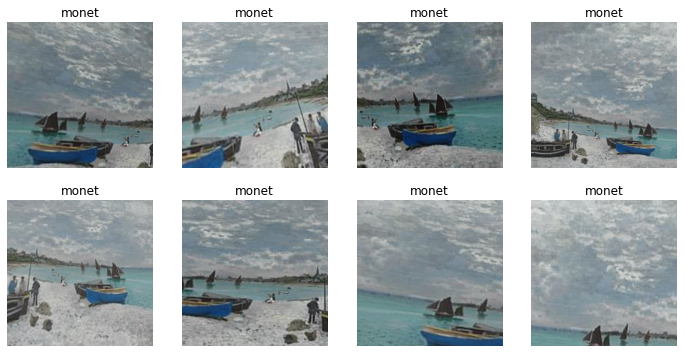

In [10]:
dls.train.show_batch(max_n=8,nrows=2,unique=True)

In [11]:
learn_34 = cnn_learner(dls, resnet34, metrics=accuracy)

In [12]:
learn_34.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.318499,1.139880,0.623574,00:08


epoch,train_loss,valid_loss,accuracy,time
0,1.434646,0.915883,0.692015,00:09
1,1.212137,0.787241,0.768061,00:09
2,1.027367,0.774204,0.764259,00:09
3,0.853558,0.715565,0.794677,00:09
4,0.738773,0.704844,0.794677,00:09


In [13]:
learn_34.save('test')

Path('models/test.pth')

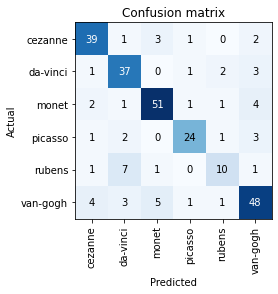

In [14]:
interp = ClassificationInterpretation.from_learner(learn_34)
interp.plot_confusion_matrix()

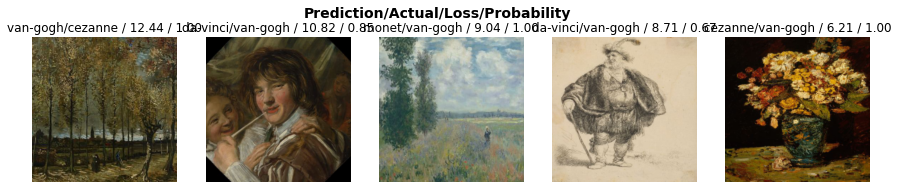

In [15]:
interp.plot_top_losses(5, nrows=1)

In [16]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn_34)
cleaner

In [17]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [18]:
learn_34.export(fname='firstmodel.pkl')

## Weighted classes

To overcome inbalanced dataset we can use weighted classes. With this approach we give our lossfunction predetermined weights we calculated. 

In Fastai this is easily done since you can set your own loss function.

In [19]:
import os
import torch

In [20]:
images = get_image_files('resources/cleaned')

In [21]:
#Calculate weights
def get_weight_of_painters(base_dir='resources/cleaned'):
    #get painter counts
    painter_counts = []
    for i in range(len(os.listdir(path=base_dir))):
        painter = os.listdir(path=base_dir)[i]
        painter_count = len(os.listdir(path=f'{base_dir}/{painter}'))
        painter_counts.append(painter_count)
    
    #calculate weights
    total = sum(painter_counts)
        
    weights = [total/(2.0*w) for w in painter_counts]
    return weights

In [22]:
class_weights = torch.Tensor(get_weight_of_painters()).cuda()
class_weights

tensor([2.1983, 2.7029, 2.8674, 3.9256, 6.6616, 2.3723], device='cuda:0')

In [23]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [24]:
learn_34_weighted = cnn_learner(dls, resnet34, loss_func=loss_func, metrics=accuracy)

In [25]:
learn_34_weighted.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,2.931693,2.113755,0.212928,00:08
1,2.511851,1.319363,0.471483,00:08
2,2.107504,1.008997,0.631179,00:08
3,1.785947,0.839568,0.703422,00:08
4,1.534214,0.810173,0.714829,00:08
5,1.329717,0.764272,0.752852,00:08
6,1.173020,0.730977,0.756654,00:08
7,1.057250,0.685440,0.764259,00:08
8,0.956419,0.657042,0.775665,00:08
9,0.857807,0.673526,0.787072,00:08


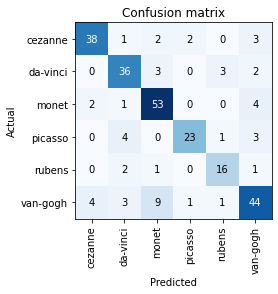

In [26]:
interp = ClassificationInterpretation.from_learner(learn_34_weighted)
interp.plot_confusion_matrix()

In [27]:
dls_smallbatch= paintings.dataloaders('resources/cleaned', num_workers=0, bs=32)

In [28]:
learn_50_weighted = cnn_learner(dls_smallbatch, resnet50, loss_func=loss_func, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/yori/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [29]:
learn_50_weighted.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.231770,1.183515,0.608365,00:14
1,1.783647,1.022265,0.699620,00:13
2,1.410769,0.910031,0.733840,00:13
3,1.148310,0.879393,0.779468,00:13
4,0.953994,0.717474,0.779468,00:13
5,0.780454,0.755955,0.802281,00:13
6,0.626119,0.694126,0.802281,00:13
7,0.542718,0.697213,0.817491,00:13
8,0.475883,0.678999,0.836502,00:13
9,0.437485,0.684146,0.825095,00:13


In [30]:
learn_50_weighted.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.511105,0.740565,0.813688,00:13
1,0.468712,0.770510,0.806084,00:12


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

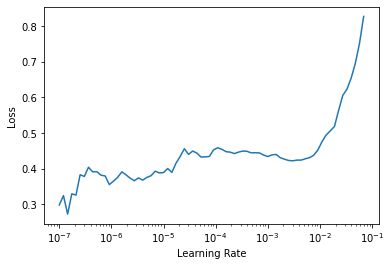

In [31]:
learn_50_weighted.lr_find()

In [32]:
learn_50_weighted.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.511978,5.823253,0.414449,00:13
1,1.451409,1.242981,0.653992,00:13


In [33]:
learn_50_weighted.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.054124,0.937672,0.722433,00:13
1,1.140268,2.234010,0.585551,00:13
2,1.238524,2.385480,0.536122,00:13
3,1.244774,1.173482,0.676806,00:13
4,1.131734,1.165094,0.673004,00:13
5,0.928230,0.829252,0.768061,00:13
6,0.763740,0.779921,0.771863,00:13
7,0.609605,0.766002,0.775665,00:13


SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=1.3182567499825382e-06)

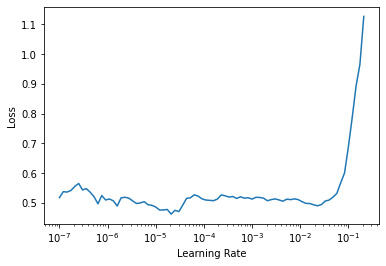

In [34]:
learn_50_weighted.lr_find()

In [ ]:
learn_50_weighted.fine_tune(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.483168,0.777301,0.775665,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.511741,0.756905,0.779468,00:16
1,0.483048,0.759205,0.783270,00:15


In [ ]:
interp = ClassificationInterpretation.from_learner(learn_50_weighted)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
learn_50_weighted.save('20ep')

In [ ]:
learn_50_weighted.export('export.pkl')